## AutoML 예측

- image내의 50x50 pixel의 구획을 위 아래로 두개 생성
- 윗부분(실제 panel)은 top으로, 아랫부분(reference panel)은 bottom으로 지정
- 50x50box내의 RGB값의 평균을 이용 -> Top RGB, Bot RGB 6개씩의 데이터를 얻어냄
- 6개의 RGB값들을 X(input)으로, Thickness를 Y(Output)으로 이용하여 학습

1. Top + Bot RGB를 이용해서 학습한 Case, MSE = 182
2. Top 만을 이용해서 학습한 Case, MSE = 80

오히려 Bottom 결과를 주는 것이 더 학습 성능이 낮아짐.

In [1]:
%pip install tpot

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
from PIL import Image 
import matplotlib.pyplot as plt
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import cv2

- Load Tabular Dataset

In [3]:
Thickness = pd.read_csv('./data/Thickness.csv')
Thickness = Thickness.drop([33]) # 9-1 drop
Thickness.reset_index(drop=True, inplace=True)
Thickness

,Thickness
0,48.266667
1,47.966667
2,48.166667
3,48.600000
4,59.533333
...,...
122,84.633333
123,98.366667
124,97.033333
125,96.266667


### 이미지 전처리

In [4]:
img_path_list = []

for i in range(1, 33):
    for j in range(1, 5):
        if i == 9 and j == 1: 
            continue
        img_path_list.append('./data/test_img/AI-{}_0{}_transformed.jpg'.format(i, j))
        
img_path_list[:5]


['./data/test_img/AI-1_01_transformed.jpg',
 './data/test_img/AI-1_02_transformed.jpg',
 './data/test_img/AI-1_03_transformed.jpg',
 './data/test_img/AI-1_04_transformed.jpg',
 './data/test_img/AI-2_01_transformed.jpg']

(1024, 1024, 3)

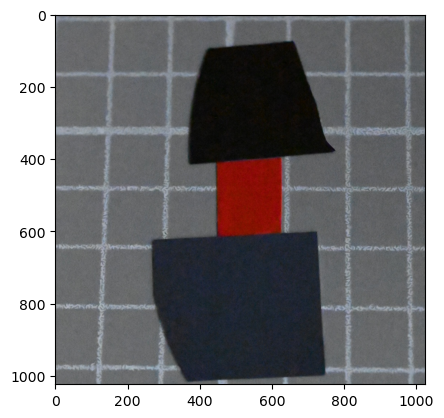

In [5]:
import matplotlib.pyplot as plt
from PIL import Image

img_path = img_path_list[0]  # Assuming img_path_list contains the path to your image
img = Image.open(img_path)

plt.imshow(img)
img = np.array(img)
img.shape

#### 실제 Panel

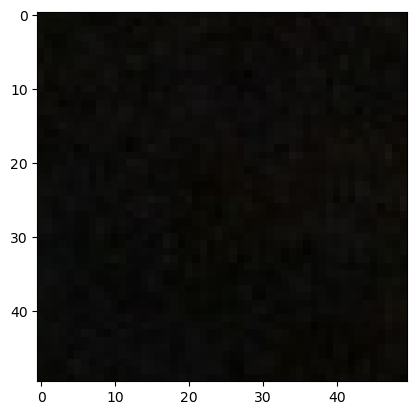

In [6]:
top_box = img[230:280,500:550]
plt.imshow(top_box)

#### 비교용 Panel

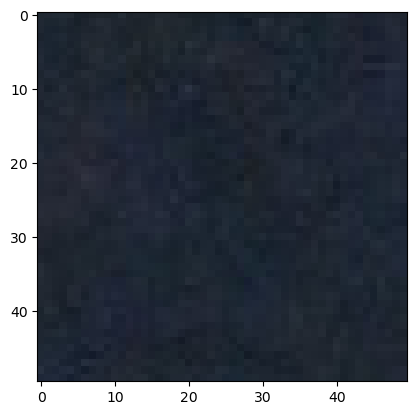

In [7]:
bottom_box = img[700:750,500:550]
plt.imshow( bottom_box)

In [8]:
Top_path = './data/box_img/Top/'
Bot_path = './data/box_img/Bot/'

for i in range(len(img_path_list)):
    img_path = img_path_list[i]
    img = Image.open(img_path)
    img = np.array(img)
    
    top_box = img[230:280,500:550]
    bottom_box = img[700:750,500:550]
    
    top_box = Image.fromarray(top_box)
    bottom_box = Image.fromarray(bottom_box)
    
    top_box.save(Top_path + 'Top_{}.jpg'.format(i))
    bottom_box.save(Bot_path + 'Bot_{}.jpg'.format(i))
    
    if i % 100 == 0:
        print(i)

0
100


In [9]:
np.mean(img, axis=(0,1)) #RGB 평균 구하기

array([84.90769768, 85.51504612, 89.61443996])

In [10]:
top_avg_rgb = []
bot_avg_rgb = []
for i in range(len(img_path_list)):
    top = Image.open(Top_path + 'Top_{}.jpg'.format(i))
    bot = Image.open(Bot_path + 'Bot_{}.jpg'.format(i))
    top = np.array(top)
    bot = np.array(bot)
    Top_R, Top_G, Top_B = np.mean(top[:, :, 0]), np.mean(top[:, :, 1]), np.mean(top[:, :, 2])
    Bot_R, Bot_G, Bot_B = np.mean(bot[:, :, 0]), np.mean(bot[:, :, 1]), np.mean(bot[:, :, 2])
    
    top_avg_rgb.append([Top_R, Top_G, Top_B])
    bot_avg_rgb.append([Bot_R, Bot_G, Bot_B])

    
    

### Reference + Original Image

- top: panel
- bot: 비교용 panel

In [11]:
Table_dataset = pd.DataFrame({'Top_R': [i[0] for i in top_avg_rgb], 'Top_G': [i[1] for i in top_avg_rgb], 'Top_B': [i[2] for i in top_avg_rgb],
              'Bot_R' : [i[0] for i in bot_avg_rgb], 'Bot_G' : [i[1] for i in bot_avg_rgb], 'Bot_B' : [i[2] for i in bot_avg_rgb],
              'Thickness': Thickness['Thickness']})

Table_dataset

,Top_R,Top_G,Top_B,Bot_R,Bot_G,Bot_B,Thickness
0,11.5760,10.8832,8.1364,30.2140,37.7740,50.4468,48.266667
1,12.4712,12.6248,11.2136,25.9992,34.8912,43.0424,47.966667
2,12.7704,12.7176,9.9168,31.3148,35.7876,41.8260,48.166667
3,11.2308,11.4564,8.8540,24.8812,32.4324,39.4952,48.600000
4,5.4696,3.2120,1.4352,26.0116,32.5420,38.0564,59.533333
...,...,...,...,...,...,...,...
122,0.5624,5.0128,22.1704,27.1852,35.2252,42.7796,84.633333
123,0.8864,15.7112,33.7552,28.0672,35.4464,40.1680,98.366667
124,1.0244,13.5756,38.8264,27.8880,36.0608,43.8560,97.033333
125,1.1264,13.7168,35.3488,30.6892,36.6848,45.9800,96.266667


In [12]:
X_train, X_test, y_train, y_test = train_test_split(Table_dataset.iloc[:, :-1], Table_dataset.iloc[:, -1], test_size=0.3, random_state=42)

In [13]:
from tpot import TPOTRegressor

tpot =  TPOTRegressor(generations=5, population_size=50, verbosity=2, random_state=42, cv=5, n_jobs = -1)
tpot.fit(X_train, y_train)

tpot.export('tpot_pipeline_cv.py')

Optimization Progress:   0%|          | 0/300 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -48.32961973911612

Generation 2 - Current best internal CV score: -48.32961973911612

Generation 3 - Current best internal CV score: -42.25566089784074

Generation 4 - Current best internal CV score: -37.11330329685484

Generation 5 - Current best internal CV score: -37.11330329685484

Best pipeline: RidgeCV(XGBRegressor(PolynomialFeatures(LinearSVR(input_matrix, C=15.0, dual=False, epsilon=0.001, loss=squared_epsilon_insensitive, tol=0.01), degree=2, include_bias=False, interaction_only=False), learning_rate=0.01, max_depth=4, min_child_weight=9, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=0.3, verbosity=0))


In [14]:
y_pred = tpot.predict(X_test)
y_pred

c:\Users\se99a\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but LinearSVR was fitted with feature names
  warnings.warn(


array([ 71.31693531,  61.09786165,  71.20988194,  99.91509242,
        99.03933996,  69.25753829,  72.26116384,  84.87491506,
        66.45314424, 107.71094919,  98.16018839,  62.19880522,
        88.4452735 ,  62.72594547,  86.12467439, 102.92709287,
        89.35506712,  84.95645054,  66.7898128 ,  85.73740159,
        73.20317388,  66.54789314,  85.34129242, 159.77569463,
        42.34623051, 100.80242418,  93.46118196,  87.50636771,
        71.45884279,  88.64007803,  64.13247445,  68.31143177,
        71.66585777, 116.23540591,  89.56788049,  87.68240237,
        72.65231345, 105.64939014,  80.19915651])

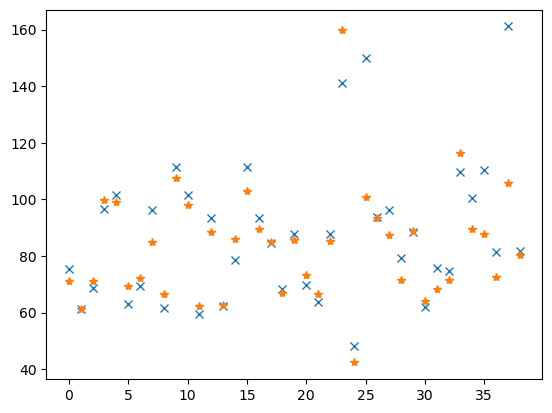

In [15]:
plt.plot(y_test.values,'x', label = 'True')
plt.plot(y_pred,'*', label = 'Predict')

In [16]:
pd.DataFrame({'True': y_test.values, 'Predict': y_pred})

,True,Predict
0,75.533333,71.316935
1,61.300000,61.097862
2,68.700000,71.209882
3,96.633333,99.915092
4,101.466667,99.039340
5,63.166667,69.257538
6,69.433333,72.261164
7,96.266667,84.874915
8,61.466667,66.453144
9,111.533333,107.710949


In [17]:
mse = np.mean((y_test.values - y_pred)**2)
mse

187.9604692177386

### Refernence 없이 진행

In [18]:
Table_dataset_only_top = Table_dataset.drop(['Bot_R', 'Bot_G', 'Bot_B'], axis = 1)
Table_dataset_only_top

,Top_R,Top_G,Top_B,Thickness
0,11.5760,10.8832,8.1364,48.266667
1,12.4712,12.6248,11.2136,47.966667
2,12.7704,12.7176,9.9168,48.166667
3,11.2308,11.4564,8.8540,48.600000
4,5.4696,3.2120,1.4352,59.533333
...,...,...,...,...
122,0.5624,5.0128,22.1704,84.633333
123,0.8864,15.7112,33.7552,98.366667
124,1.0244,13.5756,38.8264,97.033333
125,1.1264,13.7168,35.3488,96.266667


In [19]:
X_train, X_test, y_train, y_test = train_test_split(Table_dataset_only_top.iloc[:, :-1], Table_dataset_only_top.iloc[:, -1], test_size=0.3, random_state=42)

In [20]:
from tpot import TPOTRegressor

tpot =  TPOTRegressor(generations=5, population_size=50, verbosity=2, random_state=42, cv=5, n_jobs = -1)
tpot.fit(X_train, y_train)

tpot.export('tpot_pipeline_cv2.py')

Optimization Progress:   0%|          | 0/300 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -42.686667083184616

Generation 2 - Current best internal CV score: -42.686667083184616

Generation 3 - Current best internal CV score: -42.686667083184616

Generation 4 - Current best internal CV score: -42.686667083184616

Generation 5 - Current best internal CV score: -42.686667083184616

Best pipeline: AdaBoostRegressor(input_matrix, learning_rate=1.0, loss=linear, n_estimators=100)


In [21]:
y_pred = tpot.predict(X_test)
y_pred

array([ 70.56666667,  62.15555556,  71.83      ,  97.84848486,
        88.15679013,  64.41428571,  72.19444444,  91.95595238,
        66.66666666, 108.48611111,  97.17904762,  61.96904762,
        83.51809524,  63.525     ,  82.42037037, 104.00416666,
        84.79807692,  82.51111111,  70.17142857,  83.51809524,
        71.13095238,  63.84242424,  83.51809524, 153.3       ,
        48.6       , 123.55999998, 102.55641026, 102.55641026,
        71.45555555,  83.51809524,  63.84242424,  70.56666667,
        72.19444444, 108.48611111,  92.26989247, 102.2288889 ,
        71.29090909, 124.4333333 ,  76.81428571])

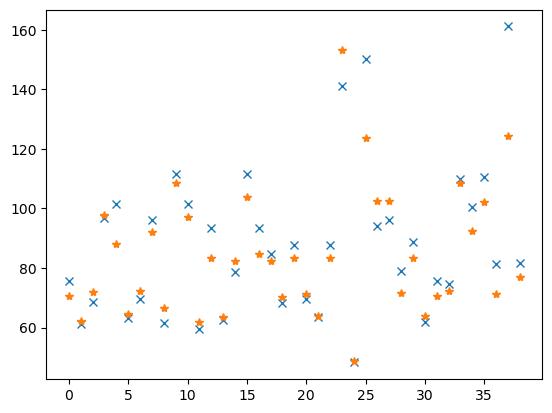

In [22]:
plt.plot(y_test.values,'x', label = 'True')
plt.plot(y_pred,'*', label = 'Predict')

In [23]:
pd.DataFrame({'True': y_test.values, 'Predict': y_pred})

,True,Predict
0,75.533333,70.566667
1,61.300000,62.155556
2,68.700000,71.830000
3,96.633333,97.848485
4,101.466667,88.156790
5,63.166667,64.414286
6,69.433333,72.194444
7,96.266667,91.955952
8,61.466667,66.666667
9,111.533333,108.486111


In [24]:
mse = np.mean((y_pred - y_test)**2)
mse

84.46143049678001